In [ ]:
import os, sys
os.chdir(os.path.dirname(sys.prefix))
# print(f"Рабочая директория: {os.getcwd()}")

In [ ]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision.transforms import v2

import os
import matplotlib.pyplot as plt
import numpy as np

import json
from tqdm import tqdm
from PIL import Image

In [ ]:
from src.tsp_dewarp.dataset import TPSDataset

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

In [ ]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((256, 256))
])

In [ ]:
DATASET_FOLDER = 'data/generated/v2/'
dataset = TPSDataset(DATASET_FOLDER, transform=transform)
len(dataset)

In [ ]:
train_data, val_data, test_data = random_split(dataset, [0.7, 0.1, 0.2])
len(train_data), len(val_data), len(test_data)

In [ ]:
BATCH_SIZE=16
train_loader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=False)

In [63]:
import torch
import torch.nn as nn
import torchvision.models as models

class TPSRegressor(nn.Module):
    def __init__(self, num_points=20):
        super().__init__()

        self.backbone = models.resnet18(weights=None)
        self.backbone.fc = nn.Identity()

        self.backbone.conv1 = nn.Conv2d(
            1, 64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )

        self.regressor = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_points * 2)
        )

    def forward(self, x):
        features = self.backbone(x)
        delta = self.regressor(features)
        return delta


In [64]:
model = TPSRegressor(num_points=49).to(device)
model

TPSRegressor(
  (backbone): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [65]:
x = train_data[1][0]
x = x.unsqueeze(0)
out = model(x)
out.shape

torch.Size([1, 98])

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

loss_model = nn.L1Loss()   # или SmoothL1Loss()
opt = torch.optim.Adam(model.parameters(), lr=1e-8)

loss_model, opt

(L1Loss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     decoupled_weight_decay: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 1e-08
     maximize: False
     weight_decay: 0
 ))

In [67]:
y_pred = torch.tensor([0.5, 0.25, 0.25])
y_true = torch.tensor([1. , 0.  , 0.  ])
loss_model(y_pred, y_true).item()

0.3333333432674408

In [76]:
EPOCHS = 8

train_loss = []
val_loss = []

for epoch in range(EPOCHS):

    # ================= TRAIN =================
    model.train()
    running_train_loss = 0.0

    train_loop = tqdm(train_loader, leave=False)

    for x, targets in train_loop:

        x = x.to(device)
        targets = targets.to(device)

        # Forward
        pred = model(x)
        loss = loss_model(pred, targets)

        # Backward
        opt.zero_grad()
        loss.backward()
        opt.step()

        running_train_loss += loss.item()

        mean_train_loss = running_train_loss / (train_loop.n + 1)

        train_loop.set_description(
            f"Epoch [{epoch+1}/{EPOCHS}] train_loss={mean_train_loss:.6f}"
        )

    mean_train_loss = running_train_loss / len(train_loader)
    train_loss.append(mean_train_loss)

    # ================= VALIDATION =================
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for x, targets in val_loader:

            x = x.to(device)
            targets = targets.to(device)

            pred = model(x)
            loss = loss_model(pred, targets)

            running_val_loss += loss.item()

    mean_val_loss = running_val_loss / len(val_loader)
    val_loss.append(mean_val_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"train_loss={mean_train_loss:.6f}, "
          f"val_loss={mean_val_loss:.6f}")


Epoch [1/8] train_loss=0.014980, val_loss=0.019138


KeyboardInterrupt: 

Epoch [5/15] train_loss=0.018592, val_loss=0.022223

In [73]:
idx = 52
x, y_target = train_data[idx]
x = x.unsqueeze(0)
model.eval()
y_pred = model.forward(x)

In [74]:
torch.round(y_pred, decimals=3), y_target

(tensor([[ 0.0160, -0.0190,  0.0100, -0.0230,  0.0000, -0.0140,  0.0110, -0.0150,
          -0.0110, -0.0110,  0.0200, -0.0100,  0.0050,  0.0270,  0.0220, -0.0100,
           0.0310, -0.0010,  0.0240, -0.0160,  0.0330, -0.0240,  0.0210, -0.0190,
           0.0220, -0.0140,  0.0120, -0.0180,  0.0200,  0.0120,  0.0010, -0.0140,
           0.0130, -0.0170,  0.0200, -0.0110,  0.0030, -0.0230,  0.0100, -0.0170,
           0.0140, -0.0220,  0.0050, -0.0110,  0.0040,  0.0090, -0.0040, -0.0130,
           0.0280,  0.0060,  0.0070, -0.0200,  0.0130, -0.0160,  0.0000, -0.0120,
          -0.0170, -0.0200,  0.0090, -0.0040,  0.0050, -0.0060, -0.0050, -0.0070,
           0.0160, -0.0140, -0.0050, -0.0250, -0.0150,  0.0010, -0.0170, -0.0110,
          -0.0170, -0.0010,  0.0000, -0.0120,  0.0090, -0.0040, -0.0110, -0.0140,
           0.0080, -0.0050,  0.0060, -0.0240,  0.0000,  0.0030,  0.0080, -0.0050,
           0.0050, -0.0120,  0.0190, -0.0040, -0.0060,  0.0140,  0.0050, -0.0090,
           0.009

In [77]:
test = torch.tensor([[1,2,3], [4,5,6]])
test

tensor([[1, 2, 3],
        [4, 5, 6]])

In [78]:
test.flatten()

tensor([1, 2, 3, 4, 5, 6])

In [79]:
test.reshape(2, 3)

tensor([[1, 2, 3],
        [4, 5, 6]])

In [81]:
import cv2

In [80]:
from src.tsp_dewarp.geometry import build_remap_from_delta_tps

In [94]:
img_path = 'data/generated/v2/latex_269_warped.png'
# img = Image.open(img_path)
img = cv2.imread('data/generated/v2/latex_269_warped.png', cv2.IMREAD_GRAYSCALE)
img

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], shape=(893, 630), dtype=uint8)

In [123]:
x_check, y_target = dataset[268]

In [124]:
model.eval()
y_pred = model.forward(x_check.unsqueeze(0)).reshape(49, 2)
y_pred, y_pred.shape

(tensor([[ 0.0468,  0.0085],
         [-0.0108,  0.0426],
         [ 0.0309,  0.0326],
         [-0.0063,  0.0016],
         [-0.0180,  0.0109],
         [-0.0236, -0.0304],
         [-0.0187, -0.0181],
         [ 0.0295,  0.0184],
         [ 0.0299,  0.0216],
         [ 0.0111,  0.0265],
         [ 0.0085, -0.0046],
         [ 0.0099, -0.0188],
         [-0.0175, -0.0260],
         [-0.0110, -0.0305],
         [ 0.0238,  0.0263],
         [ 0.0348,  0.0080],
         [ 0.0186,  0.0101],
         [ 0.0234, -0.0116],
         [-0.0030,  0.0085],
         [ 0.0237, -0.0408],
         [ 0.0199, -0.0161],
         [ 0.0293,  0.0326],
         [ 0.0180,  0.0011],
         [ 0.0167,  0.0065],
         [ 0.0240,  0.0068],
         [ 0.0326, -0.0045],
         [-0.0011, -0.0151],
         [ 0.0088, -0.0308],
         [ 0.0091, -0.0027],
         [ 0.0218,  0.0214],
         [ 0.0007,  0.0178],
         [ 0.0212,  0.0036],
         [-0.0060, -0.0201],
         [ 0.0119, -0.0167],
         [-0.0

In [126]:
delta_tps = y_pred.detach().numpy()
map_x, map_y = build_remap_from_delta_tps(
    delta_tps=delta_tps,  # (grid_size^2, 2)
    H=img.shape[0],
    W=img.shape[1],
    grid_size=7,
    clip=False # УБРАТЬ ОБРЕЗКУ!!!
)

rectified = cv2.remap(
    img,
    map_x,
    map_y,
    interpolation=cv2.INTER_CUBIC,
    borderMode=cv2.BORDER_CONSTANT,
    borderValue=255
)
cv2.imwrite('data/restored_269_1.png', rectified)

True

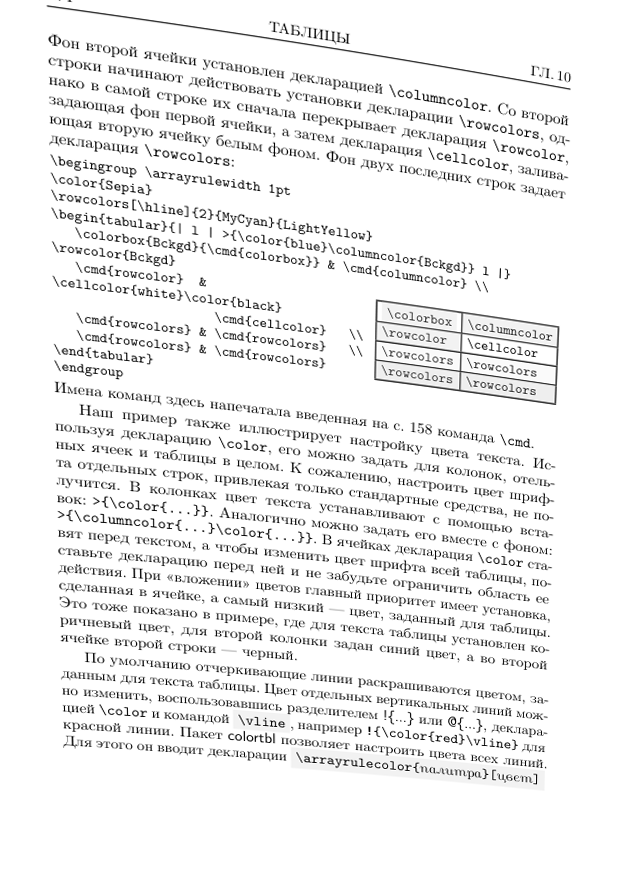

In [129]:
im = Image.open('data/generated/v2/latex_269_warped.png')
im

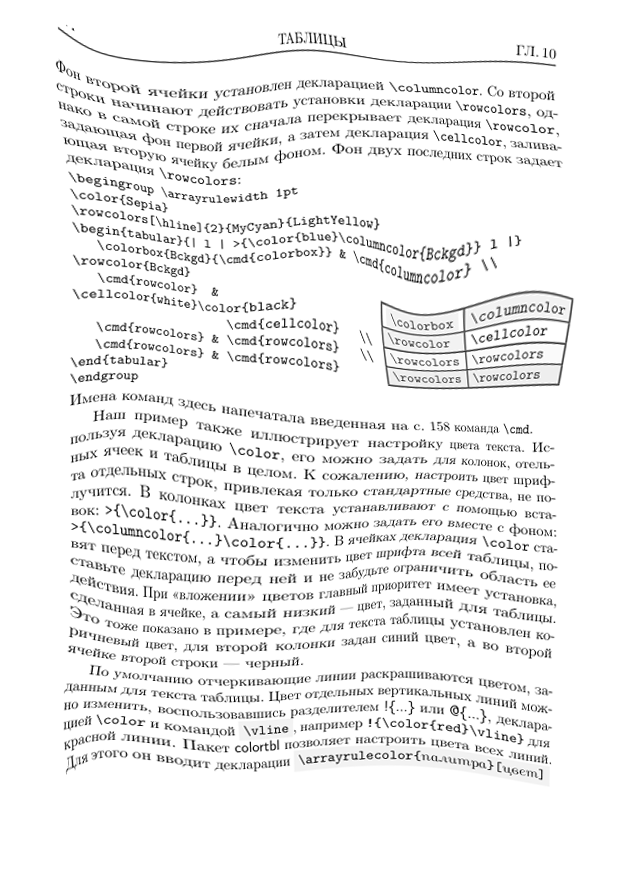

In [128]:
img_rest = Image.open('data/restored_269_1.png')
img_rest

Размерность

In [114]:
with open('data/generated/v2/metadata.json', 'r', encoding='utf-8') as f:
    metadata = json.load(f) 

In [121]:
torch.tensor(metadata[0]['deltaTPS'][:3])

tensor([[-0.0037,  0.0436],
        [-0.0226,  0.0350],
        [-0.0332,  0.0212]])

In [122]:
dataset[0][1][:6].reshape(3, 2)

tensor([[-0.0037,  0.0436],
        [-0.0226,  0.0350],
        [-0.0332,  0.0212]])

In [131]:
for i in range(1):
    print(i)

0
